# Generating Question - Answering using Transformers - DistilBERT

DistilBERT, a distilled version of BERT: it has 40% fewer parameters, runs 60% faster while preserving 97% of BERT's performance as measured on the GLUE language understanding benchmark.

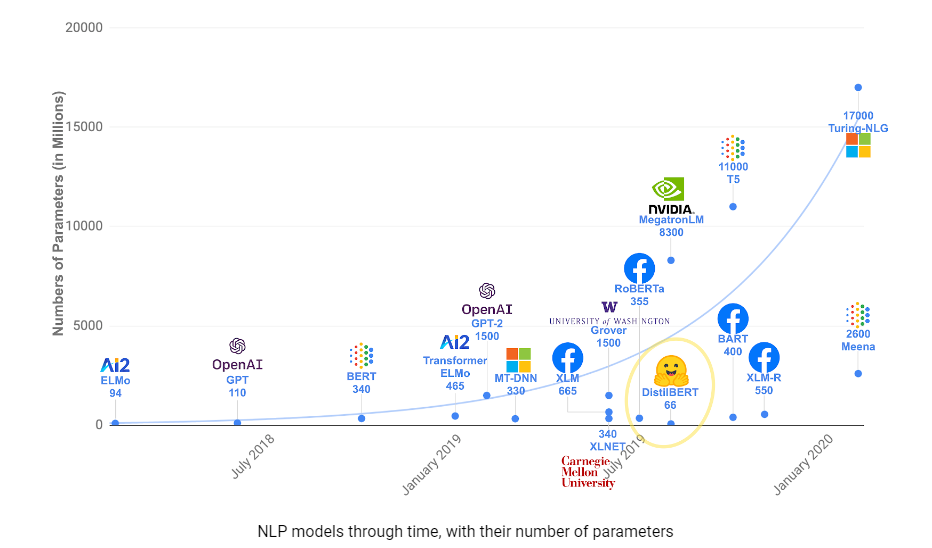

For our exercise we are using:

qa_model_name: This variable holds the name of the pre-trained model to be used for the question-answering task. The model "distilbert-base-cased-distilled-squad" is a distilled version of BERT, specifically fine-tuned for the SQuAD (Stanford Question Answering Dataset) task. It is smaller and faster than the original BERT model while maintaining a good level of performance.

qg_model_name: This variable holds the name of the pre-trained model to be used for the question generation task. The model "valhalla/t5-small-qg-hl" is a T5 model fine-tuned for question generation tasks. The T5 model (Text-to-Text Transfer Transformer) is capable of converting a variety of NLP tasks into a text-to-text format, making it versatile for tasks like translation, summarization, and question generation.

qa_pipeline: This line initializes a pipeline for question answering. The pipeline function from the transformers library creates a high-level pipeline for a specific task. Here, the task is 'question-answering', and it uses the qa_model_name specified earlier. This pipeline will take a context and a question as input and return an answer extracted from the context.





In [1]:
# Step 1: Install Required Libraries
!pip install transformers
!pip install torch
!pip install PyPDF2

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
# Step 2: Import necessary libraries
import os
import re
import torch
from transformers import pipeline
from PyPDF2 import PdfReader

In [3]:
# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()
    return text

In [4]:
# Function to split text into glossary entries
def extract_glossary_entries(text):
    glossary_start = text.find("GLOSSARY")
    glossary_text = text[glossary_start:]
    # Split by common patterns found in the document to identify individual entries
    entries = re.split(r'(?<=\.)\s*(?=[A-Z])', glossary_text)
    return [entry.strip() for entry in entries if len(entry.strip()) > 0]

In [5]:
# Function to clean text
def clean_text(text):
    text = text.replace('\n', ' ')
    text = text.replace('\xa0', ' ')
    text = ' '.join(text.split())
    return text

In [6]:
# Load models
qa_model_name = "distilbert-base-cased-distilled-squad"
qg_model_name = "valhalla/t5-small-qg-hl"

qa_pipeline = pipeline('question-answering', model=qa_model_name)
qg_pipeline = pipeline('text2text-generation', model=qg_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
# Function to generate a single question
def generate_question(context):
    highlighted_text = "<hl> " + context + " <hl>"
    qg_input = f"generate question: {highlighted_text}"
    question = qg_pipeline(qg_input)[0]['generated_text']
    return question

In [8]:
# Function to generate a single answer
def generate_answer(context, question):
    answer = qa_pipeline(question=question, context=context)
    return answer['answer']

# Step 3: Upload PDF File
from google.colab import files
uploaded = files.upload()

Saving wiki_nuclear_definitions.pdf to wiki_nuclear_definitions.pdf


In [9]:
# Assuming the first uploaded file is the PDF
pdf_path = list(uploaded.keys())[0]

In [10]:
# Step 4: Extract context from the PDF
full_text = extract_text_from_pdf(pdf_path)
cleaned_text = clean_text(full_text)
entries = extract_glossary_entries(cleaned_text)

In [11]:
# Limit to the first 25 entries
entries = entries[:25]

In [12]:
# Prepare to write to a text file
output_file = "qa_results.txt"
with open(output_file, "w") as file:
    # Step 5: Generate a single question and answer for each entry
    for entry in entries:
        file.write(f"Entry: {entry}\n\n")
        question = generate_question(entry)  # Generate 1 question per entry
        answer = generate_answer(entry, question)
        file.write(f"Q: {question}\n")
        file.write(f"A: {answer}\n\n")
        file.write("\n" + "="*50 + "\n\n")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [13]:
# Download the file
files.download(output_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>